# Data exploration and loading common structures

In [1]:
import pandas as pd
import numpy as np
import csv as csv
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices

matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
# explore training data
train_df = pd.read_csv('../../data/train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


---
After counting the number of missing data in each column, we can discard 'Cabin' since it has very little information. Further, 'Ticket' is mostly specific to passengers and can also be removed. 

In [13]:
# print("Number of unique 'Ticket' values = {0}".format(len(train_df['Ticket'].unique())))
print("---------------------------------------")
print("Missing values in each column")
print(train_df.isnull().sum())

---------------------------------------
Missing values in each column
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
Title            0
age_ranges     177
dtype: int64


In [4]:
# remove the unhelpful features
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)

------------------- Distribution of Ages ---------------------------------


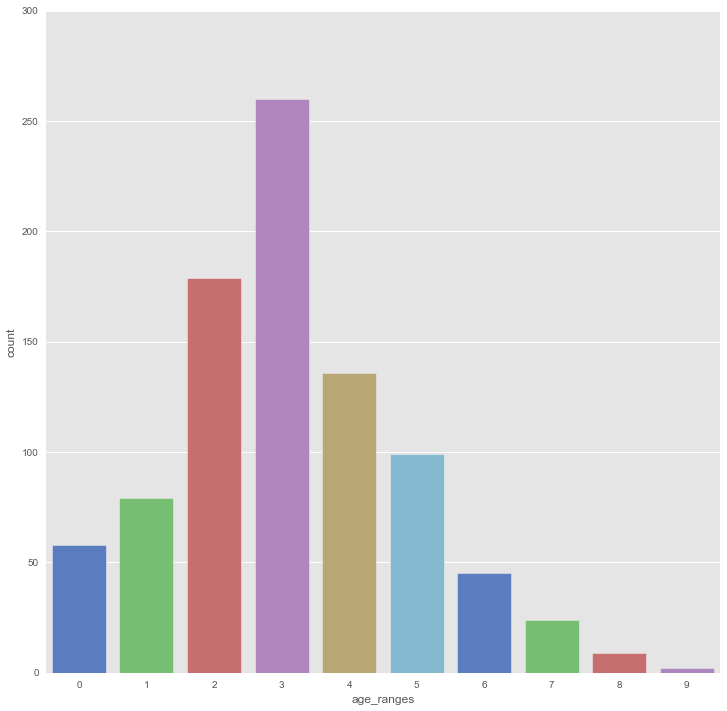

In [81]:
# distribution of age
print("------------------- Distribution of Ages ---------------------------------")
train_df['age_ranges'], age_bins = pd.cut(train_df['Age'], 10, precision=1, labels=False, retbins=True)
sns.factorplot('age_ranges', data=train_df, kind='count', size=10)
age_distribution = pd.concat((pd.DataFrame(age_bins, columns=["Age"]), 
                              train_df['age_ranges'].value_counts()), axis=1)
age_distribution.rename(columns={'age_ranges': 'Count'}, inplace=True)

In [5]:
# impute the missing Embarked and Age values
print("------------------- Imputing Embarked with mode value ---------------------------------")
train_df["Embarked"] = train_df["Embarked"].fillna(train_df["Embarked"].mode()[0])
print(train_df["Embarked"].value_counts(dropna=False))

print("------------------- Imputing Age with median ---------------------------------")
print("Median age = {0}".format(train_df["Age"].median()))
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)

------------------- Imputing Embarked with mode value ---------------------------------
S    646
C    168
Q     77
Name: Embarked, dtype: int64
------------------- Imputing Age with median ---------------------------------
Median age = 28.0


### Alternative imputation of age

In [6]:
def get_title(name):
    start = name.find(", ") + len(", ")
    end = name.find(". ")
    return name[start:end] 

train_df["Title"] = train_df["Name"].apply(lambda x: get_title(x))
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


In [7]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


In [70]:
age_for_imputation = train_df.groupby(["Pclass","Title"]).agg({'Age': np.mean})
age_median = train_df['Age'].median()
def impute_age(pclass, title):
    if (pclass, title) in age_for_imputation.index:
        return age_for_imputation.ix[(pclass, title)]['Age']
    else: 
        age_median

train_df['Age'] = [row[1]["Age"] if not np.isnan(row[1]["Age"]) else impute_age(row[1]["Pclass"], row[1]["Title"]) 
                         for row in train_df.iterrows()]

-----


## Sex and Class correlation with survival

Below plot shows that most of the class 1 and 2 females survived, while majority of the male from class 3 did not survive.

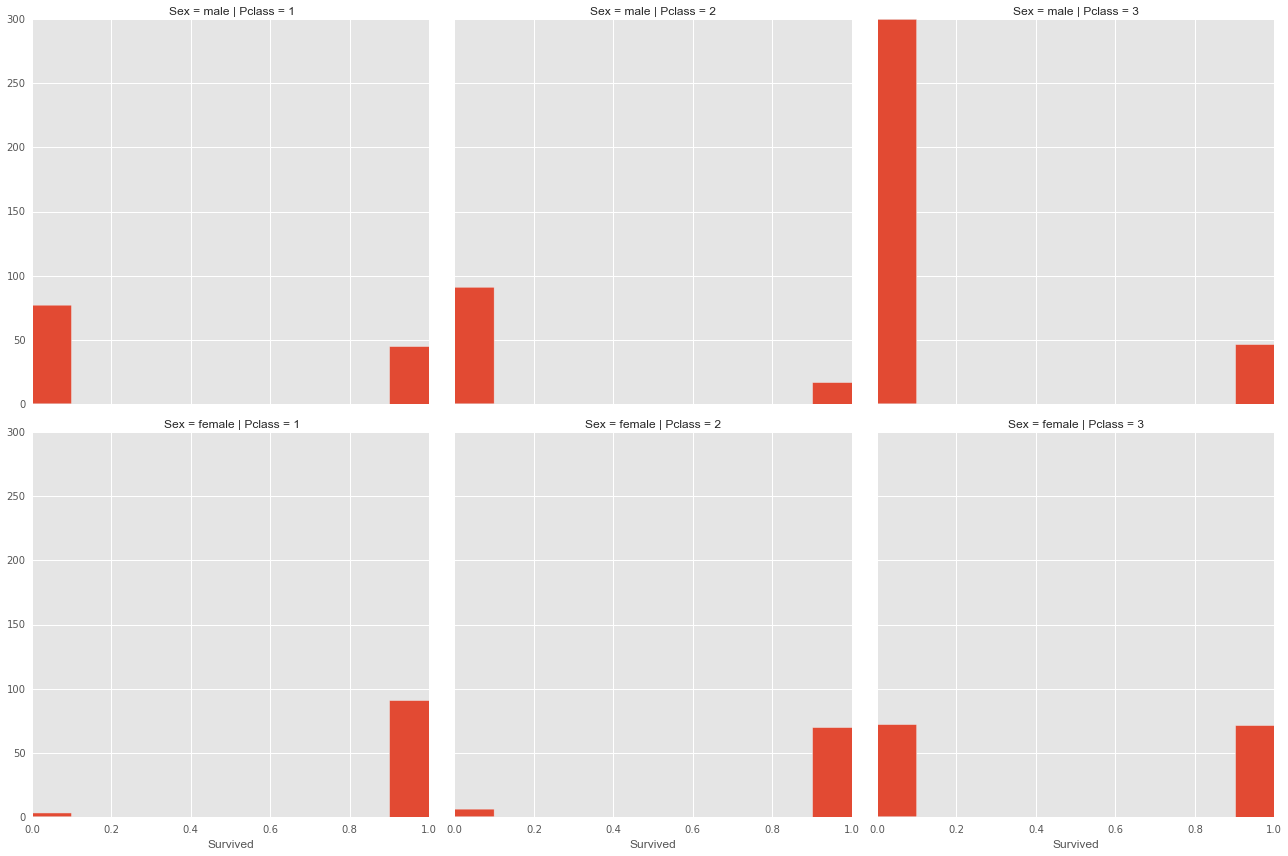

In [69]:
g = sns.FacetGrid(train_df, row="Sex", col="Pclass", col_order=[1, 2, 3], size=dddd6)
g.map(plt.hist, "Survived")

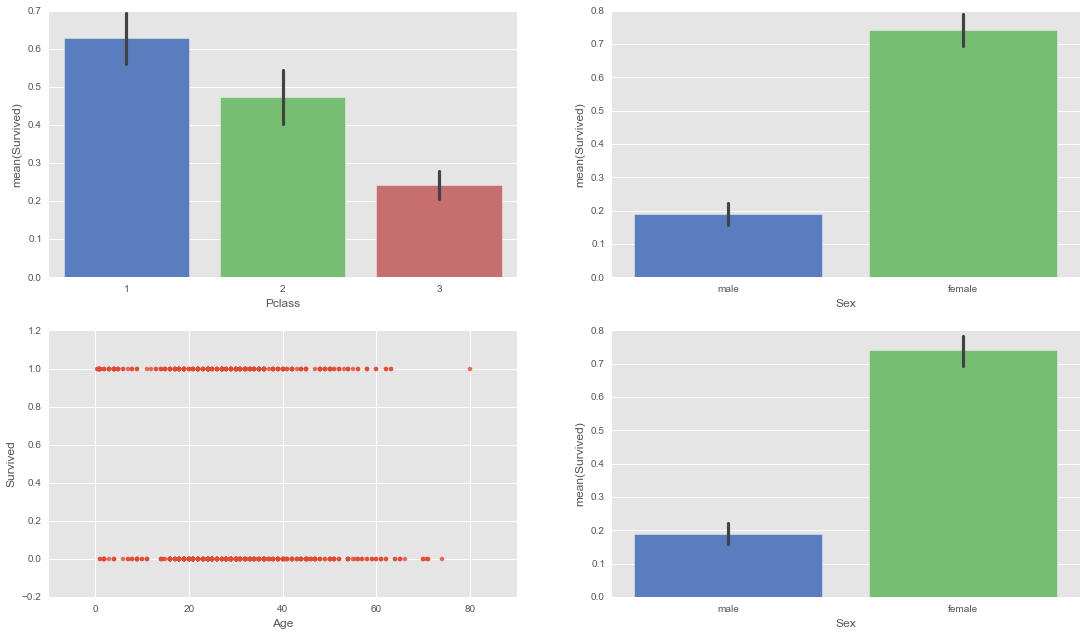

In [97]:
# Consider each feature individually
f, axes = plt.subplots(nrows=2, ncols=2)
g = sns.factorplot(x="Pclass", y="Survived",data=train_df,
                   size=6, kind="bar", palette="muted", order=[1, 2, 3], ax=axes[0, 0])
plt.close(g.fig)
g = sns.factorplot(x="Sex", y="Survived",data=train_df,
                   size=6, kind="bar", palette="muted", ax=axes[0, 1])
plt.close(g.fig)
g = sns.regplot(x="Age", y="Survived", fit_reg=False, data=train_df, ax=axes[1, 0])

g = sns.factorplot(x="Sex", y="Survived", data=train_df,
                   size=6, kind="bar", palette="muted", ax=axes[1, 1])
plt.close(g.fig)
f.set_size_inches(18.5, 10.5)

### Encoding the Sex and Embarked Column
    
We can convert the Embarked column to codes the same way we converted the Sex column. The unique values in Embarked are S, C, Q, and missing (nan). Each letter is an abbreviation of an embarkation port name.

We can dummy code the Embarked column to get numeric columns corresponding to the labels. 

In [4]:
# Replace all the occurences of male with the number 0.
train_df.loc[train_df["Sex"] == "male", "Sex"] = 0
train_df.loc[train_df["Sex"] == "female", "Sex"] = 1

# Find all the unique values for "Embarked".
print(train_df["Embarked"].unique())
train_df["Embarked"] = train_df["Embarked"].fillna('S')

embarked_dummy = pd.get_dummies(train_df["Embarked"], dummy_na=True, prefix="Embarked")
train_df = pd.concat([train_df, embarked_dummy], axis=1)
train_df.head()

['S' 'C' 'Q']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,0.0,1.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,1.0,0.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.0,0.0,1.0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,0.0,0.0,1.0,0.0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,0.0,0.0,1.0,0.0


### Machine learning methods to predict survival

In [8]:
# The columns we'll use to predict the target
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked_Q", "Embarked_S"]

# Create an acceptable formula for our machine learning algorithms
formula_ml = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + C(Embarked)'

### Load test data

In [65]:
test_df = pd.read_csv("../../data/test.csv")
test_df["Title"] = test_df["Name"].apply(lambda x: get_title(x))
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs


In [71]:
# test_df['Age'] = test_df['Age'].fillna(train_df['Age'].median())
test_df['Age'] = [row[1]["Age"] if not np.isnan(row[1]["Age"])
                   else impute_age(row[1]["Pclass"], row[1]["Title"]) 
                         for row in test_df.iterrows()]
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())
test_df['Survived'] = 1.5  # we add a dummy column to make 'dmatrices' work

In [80]:
print(test_df[test_df['Age'].isnull()])

    PassengerId  Pclass                     Name     Sex  Age  SibSp  Parch  \
88          980       3  O'Donoghue, Ms. Bridget  female  NaN      0      0   

    Ticket  Fare Cabin Embarked Title  Survived  
88  364856  7.75   NaN        Q    Ms       1.5  


In [10]:
embarked_test_dummy = pd.get_dummies(test_df["Embarked"], dummy_na=True, prefix="Embarked")
test_df = pd.concat([test_df, embarked_test_dummy], axis=1)

test_df.loc[test_df['Sex'] == 'male', 'Sex'] = 0
test_df.loc[test_df['Sex'] == 'female', 'Sex'] = 1

### Logistic regression

In [25]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression

# Initialize our algorithm
alg = LogisticRegression(random_state=1)
# Compute accuracy score for all the cross validation folds
scores = cross_validation.cross_val_score(
    alg, train_df[predictors], train_df["Survived"], cv=10)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.795800987402


In [35]:
# Train the algorithm using all the training data
alg = LogisticRegression(random_state=10)

alg.fit(train_df[predictors], train_df["Survived"])

# Make predictions using the test set
pred_log = alg.predict(test_df[predictors])

# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": pred_log
    })
submission.to_csv("../../submissions/self/log_regressor_1.csv", index=False)

### SVM

In [ ]:
from sklearn import svm
from patsy import dmatrices

# Here you can output which ever result you would like by changing the Kernel and clf.predict lines
# Change kernel here to poly, rbf or linear
# adjusting the gamma level also changes the degree to which the model is fitted

# create a regression friendly data frame
formula_ml = 'Survived ~ C(Pclass) + C(Sex) + Age'
y_train, x_train = dmatrices(formula_ml, data=train_df, return_type='matrix')

clf = svm.SVC(kernel='poly', degree=35).fit(x_train, y_train.ravel())


In [89]:
y, x = dmatrices(formula_ml, data=test_df, return_type='dataframe')
pred_svm = clf.predict(x) 

In [92]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": pred_svm.astype(int)
    })
submission.to_csv("../../submissions/self/svm_7.csv", index=False)

### Random Forests

In [44]:
# import the machine learning library that holds the randomforest
import sklearn.ensemble as ske
from sklearn.utils.class_weight import compute_class_weight

# Create the random forest model and fit the model to our training data
y, x = dmatrices(formula_ml, data=train_df, return_type='dataframe')
# RandomForestClassifier expects a 1 dimensional NumPy array, so we convert
y = np.asarray(y).ravel()

#instantiate and fit our model
cweight = compute_class_weight("balanced", [0, 1], y)
cweight = dict((i, weight) for i, weight in enumerate(cweight))
results_rf = ske.RandomForestClassifier(n_estimators=50, 
                                        class_weight=cweight, 
                                        max_features=0.7,
                                        oob_score=True, warm_start=True).fit(x, y)

# Score the results
print "OOB score: {0}".format(results_rf.oob_score_)

Mean training accuracy of Random Forest Predictions on the data was: 0.813692480359


In [45]:
test_y, test_x = dmatrices(formula_ml, data=test_df, return_type='dataframe')
res_rf = results_rf.predict(test_x)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": res_rf.astype(int)
    })
submission.to_csv("../../submissions/self/rf_1.csv", index=False)

### Boosting

In [87]:
from sklearn.ensemble import GradientBoostingClassifier
y, x = dmatrices(formula_ml, data=train_df, return_type='dataframe')
y = np.asarray(y).ravel()

#instantiate and fit our model
results_rf = GradientBoostingClassifier(n_estimators=100, 
                                        max_depth=3, 
                                        subsample=0.75,
                                        learning_rate=1,
                                        random_state=1,
                                        warm_start=True).fit(x, y)

# Score the results
print "Mean training score: {0}".format(results_rf.score(x, y))

Mean training score: 0.858585858586


In [62]:
test_y, test_x = dmatrices(formula_ml, data=test_df, return_type='dataframe')
res_rf = results_rf.predict(test_x)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": res_rf.astype(int)
    })
submission.to_csv("../../submissions/self/gbt_1.csv", index=False)